# Modelling for Flight Delay Prediction

## Import
Import of relevant packages

In [2]:
# Import 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score ,classification_report, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV

# Import models
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from xgboost import XGBClassifier, XGBRegressor

from tqdm.notebook import tqdm,trange
import time 

# Import scripts
from script_files.feature_engineering import *
from script_files.prepare_flight_data import *
from script_files.dummies import *
from script_files.predict import *

RSEED = 42

In [3]:
# Loading the data in and Shape to fit
train_df = pd.read_csv('data/final_train.csv', index_col=[0])
train_df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,delayed,domestic,dep_hour,dep_weekday,duration_min,arr_hour,flight_month,flight_month_name,year,distance
0,train_id_15674,2016-01-01 00:00:00,TU 0564,NKC,TUN,2016-01-01 00:15:00,2016-01-01 04:30:00,ATA,TU 320IMV,0.0,...,0,0,0,Friday,255.0,4,1,January,2016,3298.067996
1,train_id_15676,2016-01-01 00:00:00,TU 0714,JED,TUN,2016-01-01 00:55:00,2016-01-01 05:30:00,ATA,TU 332IFM,195.0,...,1,0,0,Friday,275.0,5,1,January,2016,3256.052105
2,train_id_15675,2016-01-01 00:00:00,TU 0614,DKR,TUN,2016-01-01 01:20:00,2016-01-01 05:55:00,ATA,TU 320IMU,49.0,...,1,0,1,Friday,275.0,5,1,January,2016,3678.974557
3,train_id_30980,2016-01-01 00:00:00,UG 0002,TUN,DJE,2016-01-01 06:15:00,2016-01-01 07:15:00,SCH,UG AT7LBD,0.0,...,0,1,6,Friday,60.0,7,1,January,2016,333.916459
4,train_id_7179,2016-01-01 00:00:00,TU 0880,TUN,AMS,2016-01-01 06:30:00,2016-01-01 09:20:00,ATA,TU 736IOP,36.0,...,1,0,6,Friday,170.0,9,1,January,2016,1770.371959


## Feature Engineering
Firstly we drop a number of columns that we should not use for modeling. Afterwards we separate the data set into features and the response that we are going to predict. 

In [4]:
# List of dropping feature for classification
drop_features_class = ['DATOP', 'ID','FLTID','STD', 'STA','target','icao_DEP', 'iata_DEP', 'name_DEP', 'city_DEP',
       'subd_DEP', 'country_DEP', 'elevation_DEP', 'lat_DEP', 'lon_DEP',
       'tz_DEP', 'icao_ARR', 'iata_ARR', 'name_ARR', 'city_ARR', 'subd_ARR',
       'country_ARR', 'elevation_ARR', 'lat_ARR', 'lon_ARR', 'tz_ARR','arr_hour', 'flight_month','delay_or_onTime', 'delayed']

In [5]:
# List of dropping feature for regression
drop_features_reg = ['DATOP', 'ID','FLTID','STD', 'STA','icao_DEP', 'iata_DEP', 'name_DEP', 'city_DEP',
       'subd_DEP', 'country_DEP', 'elevation_DEP', 'lat_DEP', 'lon_DEP',
       'tz_DEP', 'icao_ARR', 'iata_ARR', 'name_ARR', 'city_ARR', 'subd_ARR',
       'country_ARR', 'elevation_ARR', 'lat_ARR', 'lon_ARR', 'tz_ARR','arr_hour', 'flight_month','delay_or_onTime', 'target']

In [6]:
# Feature and target variable for Classification modelling
X_class = drop_column(train_df, drop_features_class)
y_class = train_df['delayed']
# Feature and target variable for Regression modelling
X_reg = drop_column(train_df.query("delayed == 1"), drop_features_reg)
y_reg = train_df.query("delayed == 1")['target']

### Shuffle and Split Data
80% of the data will be used for training and 20% for testing.  

In [7]:
# Split the 'features' and 'target' data into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, stratify=y_class, random_state=RSEED)
# Split the 'features' and 'target' data into training and testing sets for classification
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=RSEED)

# resetting indices
reset_indices(X_train_class,X_test_class,X_train_reg,X_test_reg)

# Print shape of the test and train data
print('Train data')
print('# Training data for classification:     {}'.format(X_train_class.shape[0]))
print('# Training data for regression     {}'.format(X_train_reg.shape[0]))
print('==================')
print('Test data')
print('# Test data for classification:     {}'.format(X_test_class.shape[0]))
print('# Test data for regression:     {}'.format(X_test_reg.shape[0]))


Train data
# Training data for classification:     81848
# Training data for regression     46072
Test data
# Test data for classification:     20462
# Test data for regression:     11518


## Baseline Model

Before we start training our first model, we should define a proper baseline model.

### Classification

                       Baseline Model
             F1 macro avg. score: 0.5756225441245043
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.26      0.39      8944
           1       0.63      0.96      0.76     11518

    accuracy                           0.65     20462
   macro avg       0.73      0.61      0.58     20462
weighted avg       0.72      0.65      0.60     20462

------------------------------------------------------------


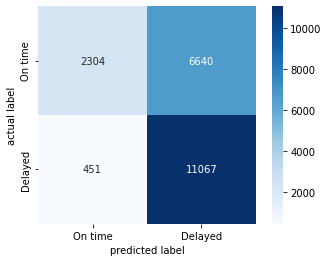

In [8]:
# Plot confusion matrix and classification report for the baseline model
# Creating a naive predictions based on the flight being domestic or not
y_pred_dumm_class = dummie_class(X_test_class)

print("                       Baseline Model")
print("==="*20)
print('             F1 macro avg. score:', f1_score(y_test_class, y_pred_dumm_class, average='macro'))
print("---"*20)
print(classification_report(y_test_class, y_pred_dumm_class))
print("---"*20)
plot_confusion_matrix(y_test_class, y_pred_dumm_class)

Our baseline model reaches a accuracy of 67% and what is even more important a F1 score of 61%. That is the value we have to beat with our more sophisticated models.

### Regression

In [9]:
# Creating a Dummie regressor that always predicts the same value
y_pred_dumm_reg = dummie_reg(X_test_reg)

In [10]:
print("                 Linear Regression Model:")
print("==="*20)
print("                 RSME:",mean_squared_error(y_test_reg, y_pred_dumm_reg,squared=False))
print("==="*20)

                 Linear Regression Model:
                 RSME: 140.09043602473963


### Error Analyse

To validate our regression models, we use a residual plot to visually confirm the validity of your model.

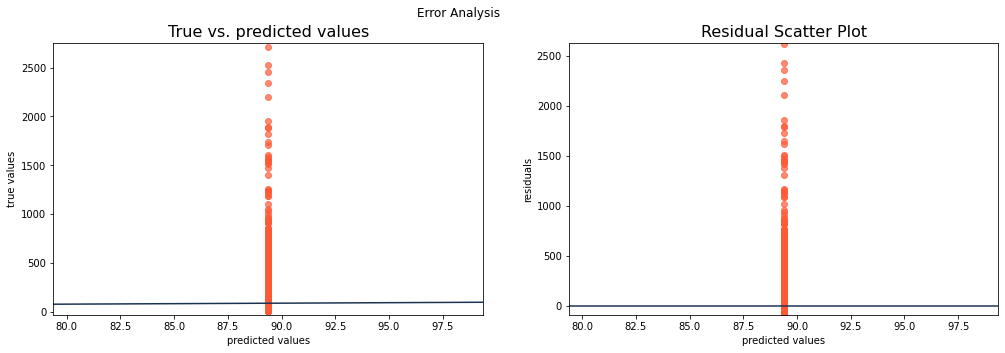

In [11]:
error_analysis(y_test_reg, y_pred_dumm_reg)

## Data Preprocessing
From the table in **Exploring the Data**, we can see there are several features for each record that are non-numeric. So we create  _"dummy"_ variables for each possible category of each non-numeric feature.

We also applying scaling to the numerical features in this case we Standatizing ensures that each numerical 

In [12]:
# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = ['DEPSTN', 'ARRSTN', 'STATUS', 'AC', 'domestic', 'dep_hour', 'dep_weekday', 'flight_month_name', 'year']

num_features = ['duration_min', 'distance']

#### Scaling and Encoding: Classification features

In [13]:
# Initialize a scaler, then apply it to the features 
scaler_class = StandardScaler()
scaler_class.fit(X_train_class[num_features])
X_train_class[num_features] = scaler_class.transform(X_train_class[num_features])
X_test_class[num_features] = scaler_class.transform(X_test_class[num_features])

# Rename the columns from the Encoded df
col = OneHotEncoder_labels(X_train_class, cat_features)

# One-hot encode the 'features' data using sklearn OneHotEncoder to Encode categorical features as a one-hot numeric array.
encoder_class = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
encoder_class.fit(X_train_class[cat_features])

# Fit OneHotEncoder to X, then transform X. Here Train Data
X_train_dummie_columns = pd.DataFrame(encoder_class.transform(X_train_class[cat_features]))
X_train_class = X_train_class.drop(cat_features, axis=1)
X_train_class = X_train_class.join(X_train_dummie_columns)
X_train_class.columns = col

# Fit OneHotEncoder to X, then transform X. Here Test Data
X_test_dummie_columns = pd.DataFrame(encoder_class.transform(X_test_class[cat_features]))
X_test_class = X_test_class.drop(cat_features, axis=1)
X_test_class = X_test_class.join(X_test_dummie_columns)
X_test_class.columns = col

#### Scaling and Encoding: Regression features

In [14]:
scaler_reg = StandardScaler()
scaler_reg.fit(X_train_reg[num_features])
X_train_reg[num_features] = scaler_reg.transform(X_train_reg[num_features])
X_test_reg[num_features] = scaler_reg.transform(X_test_reg[num_features])

col2 = OneHotEncoder_labels(X_train_reg, cat_features)

encoder_reg = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
encoder_reg.fit(X_train_reg[cat_features])

X_train_dummie_columns = pd.DataFrame(encoder_reg.transform(X_train_reg[cat_features]))
X_train_reg = X_train_reg.drop(cat_features, axis=1)
X_train_reg = X_train_reg.join(X_train_dummie_columns)
X_train_reg.columns = col2

X_test_dummie_columns = pd.DataFrame(encoder_reg.transform(X_test_reg[cat_features]))
X_test_reg = X_test_reg.drop(cat_features, axis=1)
X_test_reg = X_test_reg.join(X_test_dummie_columns)
X_test_reg.columns = col2

### Train and Compare the Models
After we got our benchmark via the baseline model, we can now test different model types to figure out which ones can handle our data best. So in the next step we will train, evaluate and compare different models.

##### __Classification Models__
We import 9 classifiers to be contenders for the best classifier.


In [15]:
# List of individual classification models stored as a tuple with name and classifier function.
model_class = classification_models()

In [16]:
model_class

[('KNN', KNeighborsClassifier()),
 ('SVC', SVC()),
 ('LR', LogisticRegression()),
 ('DT', DecisionTreeClassifier()),
 ('RF', RandomForestClassifier()),
 ('GNB', GaussianNB()),
 ('XGB',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, gamma=None,
                gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, predictor=None, random_state=None,
                reg_alpha=None, reg_lambda=None, ...)),
 ('ADA', AdaBoostClassifier()),
 ('SGD', SGDClassi

In [17]:
# Test different types of models
names = []
f1_scores = []
i = 0

# loop through the lists created over it and store the scores in the lists to reflect them with name and value
for name, model in tqdm(model_class, desc="Classification Model"):

    model.fit(X_train_class, y_train_class)
    y_pred_class = model.predict(X_test_class)
    # Collect results on the learners
    f1_scores.append(f1_score(y_test_class, y_pred_class))
    names.append(name)
    print(f"{i+1}",names[i])
    i += 1
print("Loop completed")

tr_split_class = pd.DataFrame({'Name': names,"F1":f1_scores})
print(tr_split_class)

Classification Model:   0%|          | 0/9 [00:00<?, ?it/s]

1 KNN


In [ ]:
model_class

NameError: name 'model_class' is not defined

In [ ]:
# Plot the confusion matrix for each of the 9 models
for i in range(len(model_class)):
    print(names[i])
    print(classification_report(y_test_class, y_pred_class[i]))
    plot_confusion_matrix(y_test_class, y_pred_class[i])

KNN


TypeError: Singleton array 1 cannot be considered a valid collection.

##### __Regression Models__

We import 8 regression models to be contenders for the best delay prediction.

In [ ]:
# List of individual regression models stored as a tuple with name and regression function
models_reg = regression_models()

In [ ]:
# Test different types of models
names = []
RSME = []
i = 0

# loop
for name, model in tqdm(models_reg,desc= "Regression Model"):
    model.fit(X_train_reg, y_train_reg)
    y_pred_reg = model.predict(X_test_reg)
    # Collect results on the learners
    RSME.append(mean_squared_error(y_test_reg, y_pred_reg,squared=False))
    names.append(name)
    print(f"{i+1}",names[i])
    i += 1

print("Loop completed")
    
tr_split_reg = pd.DataFrame({'Name': names,"RSME":RSME})
print(tr_split_reg)

Regression Model:   0%|          | 0/8 [00:00<?, ?it/s]

1 KNN
2 LREG


In [ ]:
# Plot the scores as a Barchart in this case lower is better because we plot the RSME
axis = sns.barplot(x = 'Name', y = 'RSME', data = tr_split_reg)
axis.set(xlabel='Regression', ylabel='RSME')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

### Hyperparameter Tuning
We pick now the two most promising models for Classification aswell as for  Regression and using grid search (`GridSearchCV`) with different parameter/value combinations, to tune our model for even better results.

---
##### __Model Tuning for Classification__

For our Classification SVC and XGB with gbtree are the best models in average F1 score. So we will do the first GridSearch on them

---

##### Hyperparameter Tuning SVC

In [ ]:
# Initialize the SVC classifier
SVC_clf = SVC(kernel='rbf',cache_size=1000) 

# Create the parameters list 
parameters = {'C':[0.01, 0.1, 1, 10],                 
              'gamma':[0.01, 0.06, 0.1, 0.6]                          
             } 

# making a macro average f1 scorer
scorer = make_scorer(f1_score,average='macro') 


# Perform grid search on the classifier using macro average f1 score as the scoring method
SVC_gridsearch = HalvingGridSearchCV(SVC_clf, parameters, scoring=scorer, cv=3, verbose=4)

# Fit the grid search object to the training data and find the optimal parameters
SVC_gridsearch.fit(X_train_class, y_train_class)


In [ ]:
# Returning best score after GridSearch and parameter combination
print("                Best score:", SVC_gridsearch.best_score_.round(4))
print("Best parameter combination:", SVC_gridsearch.best_params_)
best_SVC_clf = SVC_gridsearch.best_estimator_

##### Hyperparameter Tuning XGBoost

In [ ]:
# Initialize the XGB classifier
XGB_clf = XGBClassifier() 

# Create the parameters list 
parameters_XGB = {'eta':[0.1,0.3,0.7],                 
                'gamma':[0, 0.1, 1],
                'max_depth':[3,6,9,12],  
                'min_child_weight':[1,5,10],
                'subsample':[0.5, 0.8, 1],  
                'lambda':[0,0.5,1],
                'alpha':[0,0.5,1]              
             } 

# making a macro average f1 scorer
scorer = make_scorer(f1_score,average='macro') 

# Perform grid search on the classifier using macro average f1 score as the scoring method
XGB_gridsearch = HalvingGridSearchCV(XGB_clf, parameters_XGB, scoring=scorer, cv=5, verbose=4)

# Fit the grid search object to the training data and find the optimal parameters
XGB_gridsearch.fit(X_train_class, y_train_class)


In [ ]:
# Returning best score after GridSearch and parameter combination
print("                Best score:", XGB_gridsearch.best_score_.round(4))
print("Best parameter combination:", XGB_gridsearch.best_params_)
best_XGB_clf = XGB_gridsearch.best_estimator_

### Model Evaluation: Classification

##### __Support Vector Classifier__

In [ ]:
# Plot confusion matrix and classification report for best Support Vector Classifier model
SVC_best_predictions = best_SVC_clf.predict(X_test_class)

print("Support Vector Classifier on test data")
print("==="*20)
print("Optimal SVC F1 macro average:", f1_score(y_test_class, SVC_best_predictions, average="marco").round(4))
print("---"*20)
print(classification_report(y_test_class, SVC_best_predictions))
print("---"*20)

cm = confusion_matrix(y_test_class, SVC_best_predictions)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

##### __XGBoost Classifier__

In [ ]:
# Plot confusion matrix and classification report for best XGBoost Classifier model
XGB_best_predictions = best_XGB_clf.predict(X_test_class)

print("Support Vector Classifier on test data")
print("==="*20)
print("Optimal XGB F1 macro average:", f1_score(y_test_class, XGB_best_predictions, average="marco").round(4))
print("---"*20)
print(classification_report(y_test_class, XGB_best_predictions))
print("---"*20)

cm = confusion_matrix(y_test_class, XGB_best_predictions)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

---
##### __Model Tuning for Regression__

We search for the best parameters for SGD Regressor as they have the lowest MSE.

##### Hyperparameter Tuning SGD

In [ ]:
sgd_regression = SGDRegressor()

# Defining parameter grid (as dictionary)
param_grid_sgd = {"loss" : ["squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"],
              "alpha" : np.linspace(0.0001, 0.5, 500),
              "penalty" : ["l2", "l1", "elasticnet"]}

#Instantiate gridsearch and define the metric to optimize 
gs_sgd = GridSearchCV(SGDRegressor(random_state=RSEED), param_grid=param_grid_sgd, scoring= 'r2', verbose=4, n_jobs=-1, error_score="raise")

gs_sgd.fit(X_train_reg, y_train_reg)

In [ ]:
# Returning best score after GridSearch and parameter combination
print("                Best score:", gs_sgd .best_score_.round(4))
print("Best parameter combination:",  gs_sgd .best_params_)
gs_sgd_best_model = gs_sgd .best_estimator_

### Model Evaluation: Regression

In [ ]:
# Making predictions on the test set
y_pred_best_sgd = gs_sgd_best_model.predict(X_test_reg)

print("Linear Regression on test data")
print("==="*20)
print('Mean Squared Error:', mean_squared_error(y_test_reg, y_pred_best_sgd))
print("---"*20)
print('R2:', r2_score(y_test_reg, y_pred_best_sgd))
print("---"*20)
error_analysis(y_test_reg, y_pred_best_sgd)